# 1. Import libs

In [1]:
import pandas as pd
from optbinning import BinningProcess

(CVXPY) Sep 16 10:24:30 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Sep 16 10:24:30 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [2]:
data = pd.read_csv(r'Leads.csv')

In [3]:
data.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


## i. Defined functions


In [4]:
def select_correlated_iv_features(data, feature_list, iv_dataframe):
    correlation_matrix = data[feature_list].corr()

    # Creating an upper triangle mask
    upper_triangle_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Setting up the plot
    fig, ax = plt.subplots(figsize=(20, 20))
    color_map = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Plotting the heatmap with the mask applied
    sns.heatmap(correlation_matrix, cmap=color_map, mask=upper_triangle_mask, vmax=1, center=0.5,
                square=True, linewidths=.5, cbar_kws={"shrink": .6}, annot=True)

    plt.title("Pearson Correlation", fontsize=10)
    plt.show()

    # Resetting the index for easier processing
    correlation_matrix = correlation_matrix.reset_index()
    vars_to_remove = []

    # Identifying variables to remove based on correlation and IV values
    for column in correlation_matrix.columns[1:]:
        for i in range(len(correlation_matrix[column])):
            variable_i = correlation_matrix["index"][i]
            if (abs(correlation_matrix[column][i]) > 0.6) and (variable_i != column):
                iv_var_i = iv_dataframe.loc[iv_dataframe["variable"] == variable_i, "iv"].item()
                iv_var_col = iv_dataframe.loc[iv_dataframe["variable"] == column, "iv"].item()
                remove_variable = column if iv_var_col < iv_var_i else variable_i
                if remove_variable not in vars_to_remove:
                    vars_to_remove.append(remove_variable)

    # Selecting variables based on IV threshold
    selected_features = [var for var in feature_list if var not in vars_to_remove]
    selected_features = list(iv_dataframe[(iv_dataframe['variable'].isin(selected_features)) & 
                                          (iv_dataframe['iv'] > 0.07)]['variable'])
    
    return selected_features, vars_to_remove


def auto_binning_process(data, numerical_vars, categorical_vars):
    binning_results = []
    binning_tables = {}
    
    # Initializing the binning process
    binning_process = BinningProcess(variable_names=numerical_vars + categorical_vars, 
                                     categorical_variables=categorical_vars, 
                                     max_n_bins=5, split_digits=4)
    
    # Fitting the binning process to the data
    binning_process.fit(data, data['Converted'])
    
    # Processing each variable for binning
    for variable in data.columns:
        optimal_binning = binning_process.get_binned_variable(variable)
        binning_table = optimal_binning.binning_table.build()
        binning_table = binning_table[binning_table['Event'] > 0]
        
        # Storing the binning table
        binning_tables[variable] = binning_table
        
        # Appending the IV and binning information to the results
        binning_results.append([variable,
                                binning_table.loc['Totals', 'IV'],
                                binning_table.shape[0] - 1,
                                binning_table.loc[binning_table.drop('Totals')['Count'].idxmax(), 'Bin'],
                                binning_table.drop('Totals')['Count'].max()
                               ])
    
    # Creating a dataframe for the IV values
    iv_dataframe = pd.DataFrame(binning_results, columns=['variable', 'iv', 'unique_bin', 'top_bin', 'freq_bin'])
    
    # Concatenating all binning tables into a single dataframe
    concatenated_binning_table = pd.concat(binning_tables, axis=0)
    
    return binning_process, iv_dataframe, concatenated_binning_table


In [5]:
data = data.drop(columns = ['Prospect ID', 'Lead Number'])
data.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


### Numeric & categorical variables

In [6]:
def choose_numeric_categorical(data):
    numeric_vars = data.select_dtypes(include=['number']).columns.tolist()
    categorical_vars = data.select_dtypes(include=['object', 'category']).columns.tolist()
    return numeric_vars, categorical_vars
numeric_vars, categorical_vars = choose_numeric_categorical(data)

In [7]:
numeric_vars

['Converted',
 'TotalVisits',
 'Total Time Spent on Website',
 'Page Views Per Visit',
 'Asymmetrique Activity Score',
 'Asymmetrique Profile Score']

In [8]:
categorical_vars

['Lead Origin',
 'Lead Source',
 'Do Not Email',
 'Do Not Call',
 'Last Activity',
 'Country',
 'Specialization',
 'How did you hear about X Education',
 'What is your current occupation',
 'What matters most to you in choosing a course',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Tags',
 'Lead Quality',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'Lead Profile',
 'City',
 'Asymmetrique Activity Index',
 'Asymmetrique Profile Index',
 'I agree to pay the amount through cheque',
 'A free copy of Mastering The Interview',
 'Last Notable Activity']

### Check missing values

In [9]:
missing_values_percentage = round(100 * (data.isna().sum() / len(data)), 2)
sorted_missing_values_percentage = missing_values_percentage.sort_values(ascending=False)
sorted_missing_values_percentage

Lead Quality                                     51.59
Asymmetrique Activity Index                      45.65
Asymmetrique Profile Score                       45.65
Asymmetrique Profile Index                       45.65
Asymmetrique Activity Score                      45.65
Tags                                             36.29
Lead Profile                                     29.32
What matters most to you in choosing a course    29.32
What is your current occupation                  29.11
Country                                          26.63
How did you hear about X Education               23.89
Specialization                                   15.56
City                                             15.37
Page Views Per Visit                              1.48
TotalVisits                                       1.48
Last Activity                                     1.11
Lead Source                                       0.39
I agree to pay the amount through cheque          0.00
A free cop

### Data exploration

Converted
25th percentile: 0.0
50th percentile: 0.0
75th percentile: 1.0
90th percentile: 1.0
99th percentile: 1.0


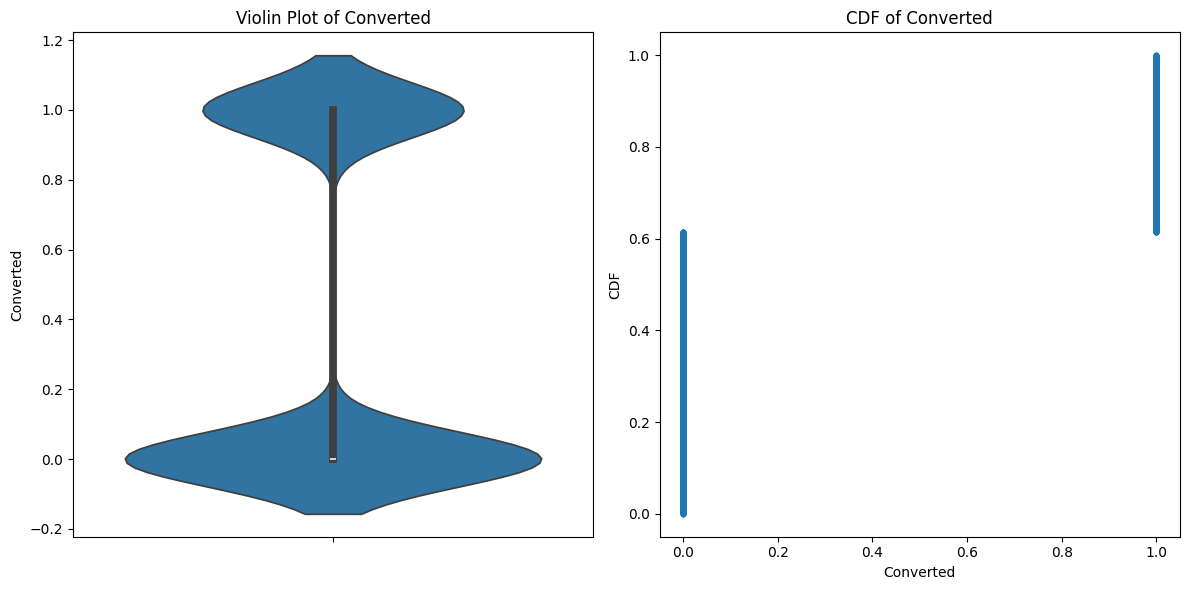

TotalVisits
25th percentile: 1.0
50th percentile: 3.0
75th percentile: 5.0
90th percentile: 7.0
99th percentile: 17.0


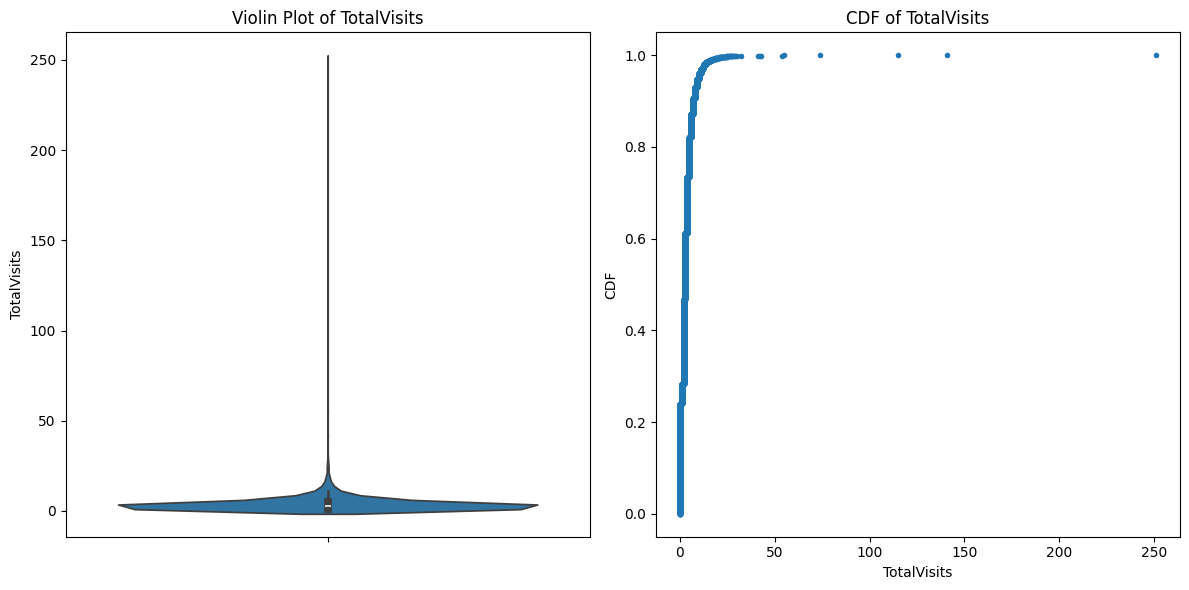

Total Time Spent on Website
25th percentile: 12.0
50th percentile: 248.0
75th percentile: 936.0
90th percentile: 1380.0
99th percentile: 1840.6100000000006


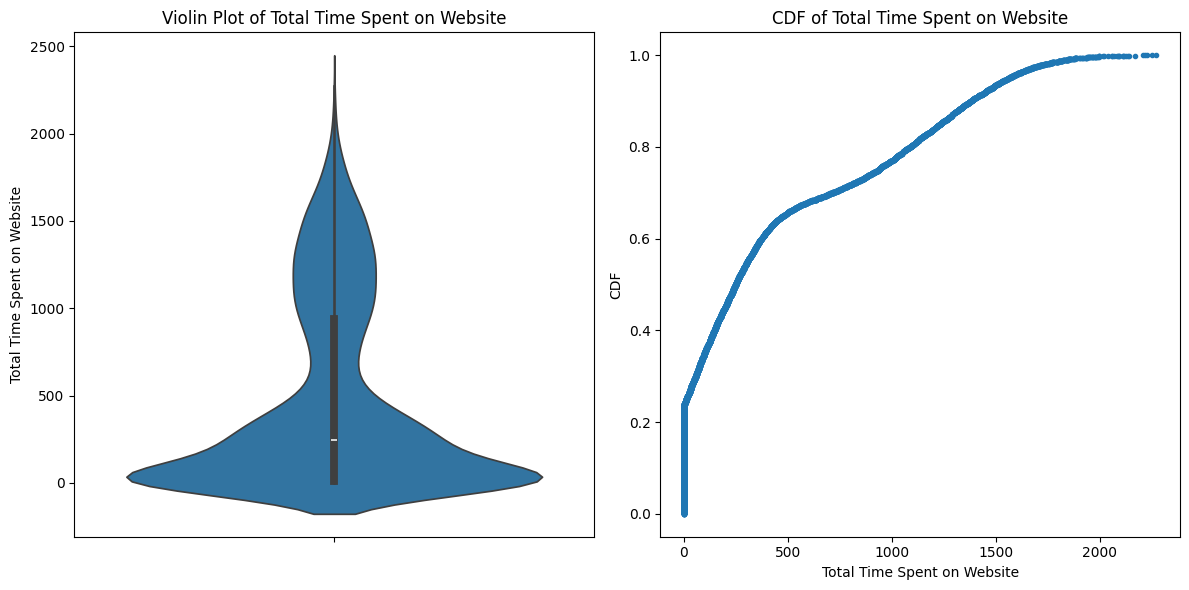

Page Views Per Visit
25th percentile: 1.0
50th percentile: 2.0
75th percentile: 3.0
90th percentile: 5.0
99th percentile: 9.0


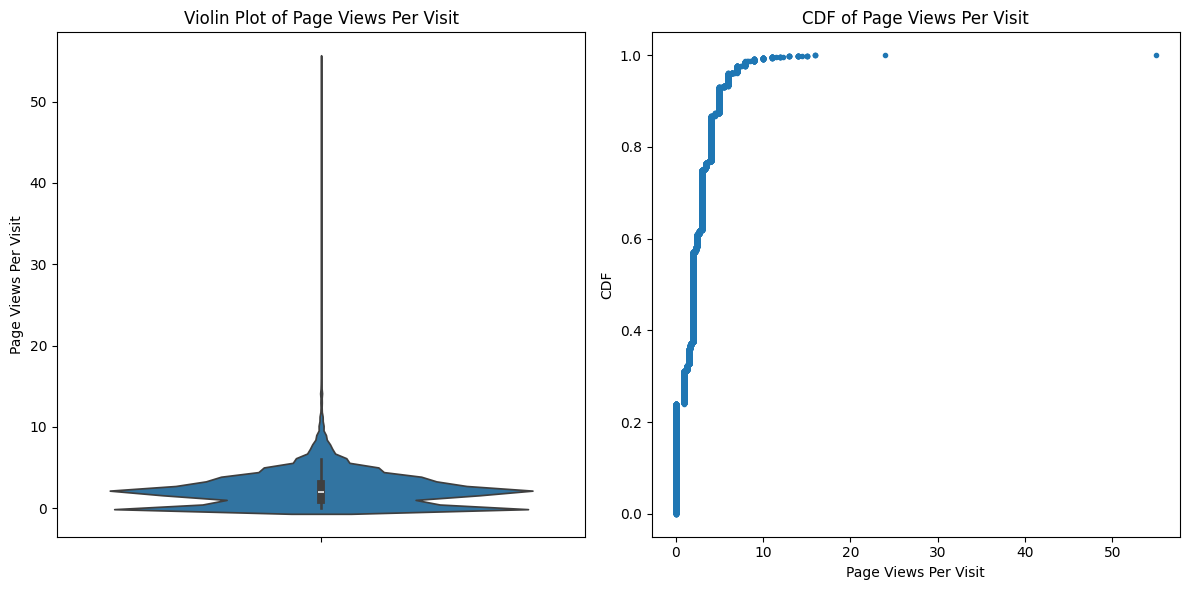

Asymmetrique Activity Score
25th percentile: 14.0
50th percentile: 14.0
75th percentile: 15.0
90th percentile: 16.0
99th percentile: 17.0


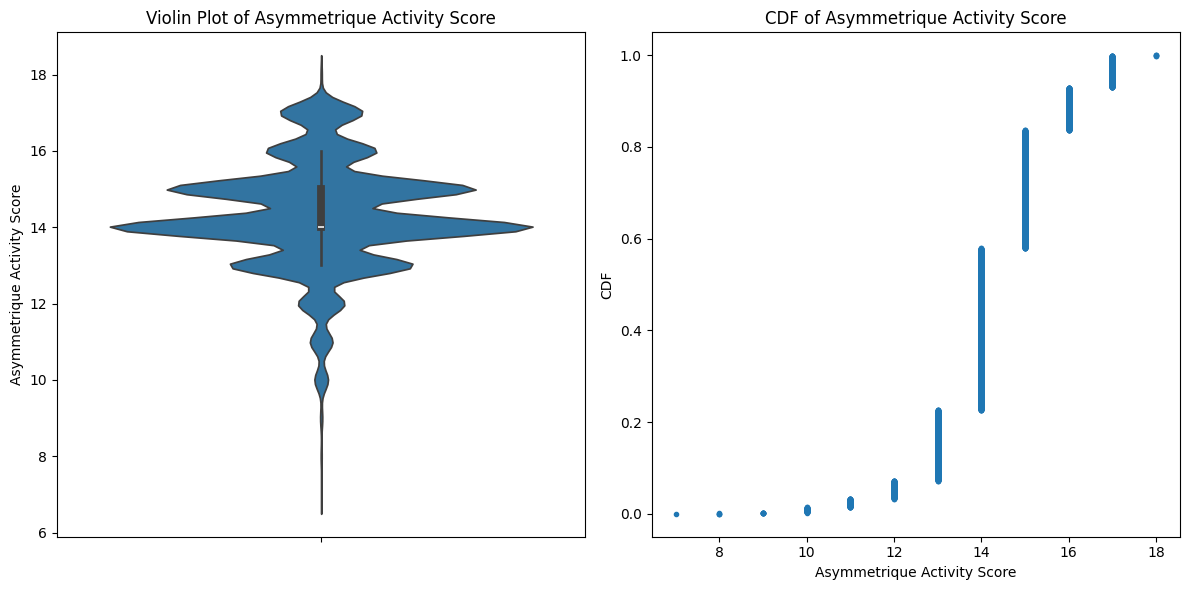

Asymmetrique Profile Score
25th percentile: 15.0
50th percentile: 16.0
75th percentile: 18.0
90th percentile: 19.0
99th percentile: 20.0


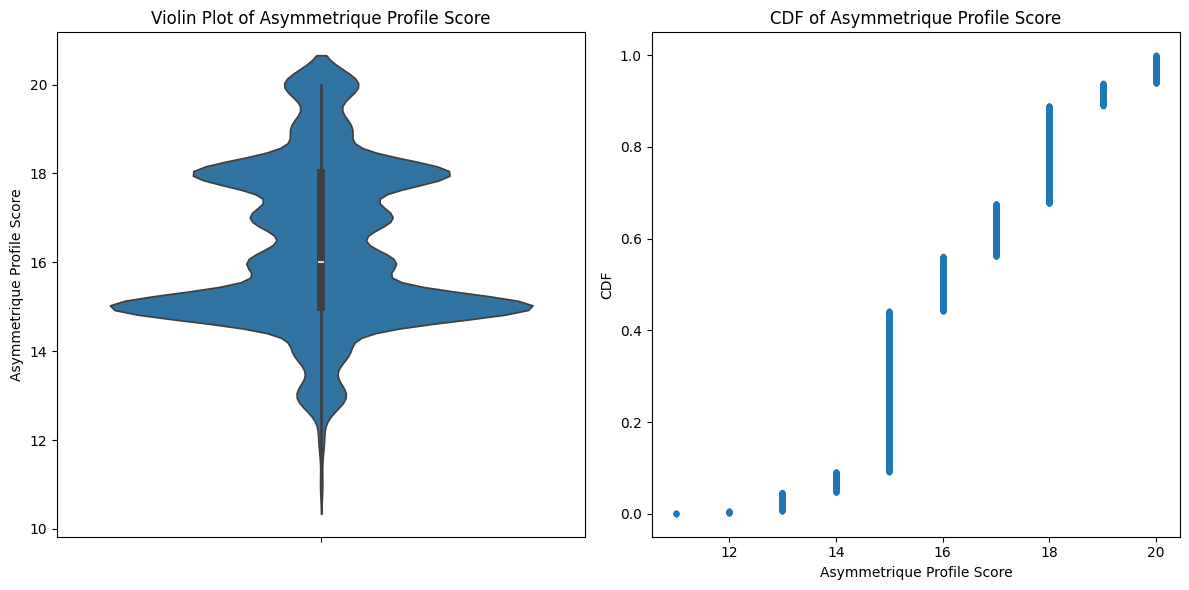

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_numeric_variable_analysis(numeric_columns, dataframe):
    for numeric_column in numeric_columns:
        plt.figure(figsize=(12, 6))
        print(numeric_column)

        # Calculate quartiles
        quartiles = np.percentile(dataframe[numeric_column].dropna(), [25, 50, 75, 90, 99])
        print(f'25th percentile: {quartiles[0]}')
        print(f'50th percentile: {quartiles[1]}')
        print(f'75th percentile: {quartiles[2]}')
        print(f'90th percentile: {quartiles[3]}')
        print(f'99th percentile: {quartiles[4]}')

        # Plot Violin plot
        plt.subplot(1, 2, 1)
        sns.violinplot(y=dataframe[numeric_column])
        plt.title(f'Violin Plot of {numeric_column}')
        plt.ylabel(numeric_column)

        # Plot CDF (Cumulative Distribution Function)
        plt.subplot(1, 2, 2)
        sorted_values = np.sort(dataframe[numeric_column].dropna())
        cdf_values = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
        plt.plot(sorted_values, cdf_values, marker='.', linestyle='none')
        plt.title(f'CDF of {numeric_column}')
        plt.xlabel(numeric_column)
        plt.ylabel('CDF')

        plt.tight_layout()
        plt.show()

plot_numeric_variable_analysis(numeric_vars, data)

### Data label encoder for categories

In [11]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply LabelEncoder to each categorical column
for col in categorical_vars:
    data[col] = label_encoder.fit_transform(data[col])

# Display the first few rows of the updated DataFrame
data.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,0,6,0,0,0,0.0,0,0.0,10,38,...,0,4,4,1,1,15.0,15.0,0,0,8
1,0,7,0,0,0,5.0,674,2.5,5,12,...,0,4,4,1,1,15.0,15.0,0,0,4
2,1,1,0,0,1,2.0,1532,2.0,5,12,...,0,3,0,1,0,14.0,20.0,0,1,4
3,1,1,0,0,0,1.0,305,1.0,13,12,...,0,4,0,1,0,13.0,17.0,0,0,8
4,1,3,0,0,1,2.0,1428,1.0,1,12,...,0,4,0,1,0,15.0,18.0,0,0,8


In [12]:
missing_values_percentage = round(100 * (data.isna().sum() / len(data)), 2)
sorted_missing_values_percentage = missing_values_percentage.sort_values(ascending=False)
sorted_missing_values_percentage

Asymmetrique Profile Score                       45.65
Asymmetrique Activity Score                      45.65
TotalVisits                                       1.48
Page Views Per Visit                              1.48
Lead Origin                                       0.00
Lead Profile                                      0.00
Receive More Updates About Our Courses            0.00
Tags                                              0.00
Lead Quality                                      0.00
Update me on Supply Chain Content                 0.00
Get updates on DM Content                         0.00
Asymmetrique Activity Index                       0.00
City                                              0.00
Digital Advertisement                             0.00
Asymmetrique Profile Index                        0.00
I agree to pay the amount through cheque          0.00
A free copy of Mastering The Interview            0.00
Through Recommendations                           0.00
X Educatio

It looks like there are some outliers in the data. We will use feture selection to consider that outlier in 'View Per Visit' are useful or not

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
trained_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Converted'])


In [14]:
binning_process, iv, df_binning_table = auto_binning_process(trained_data[categorical_vars+numeric_vars],numeric_vars,categorical_vars)

In [15]:
iv.to_csv(r'iv_table.csv')
df_binning_table.to_csv(r'binning_table.csv')

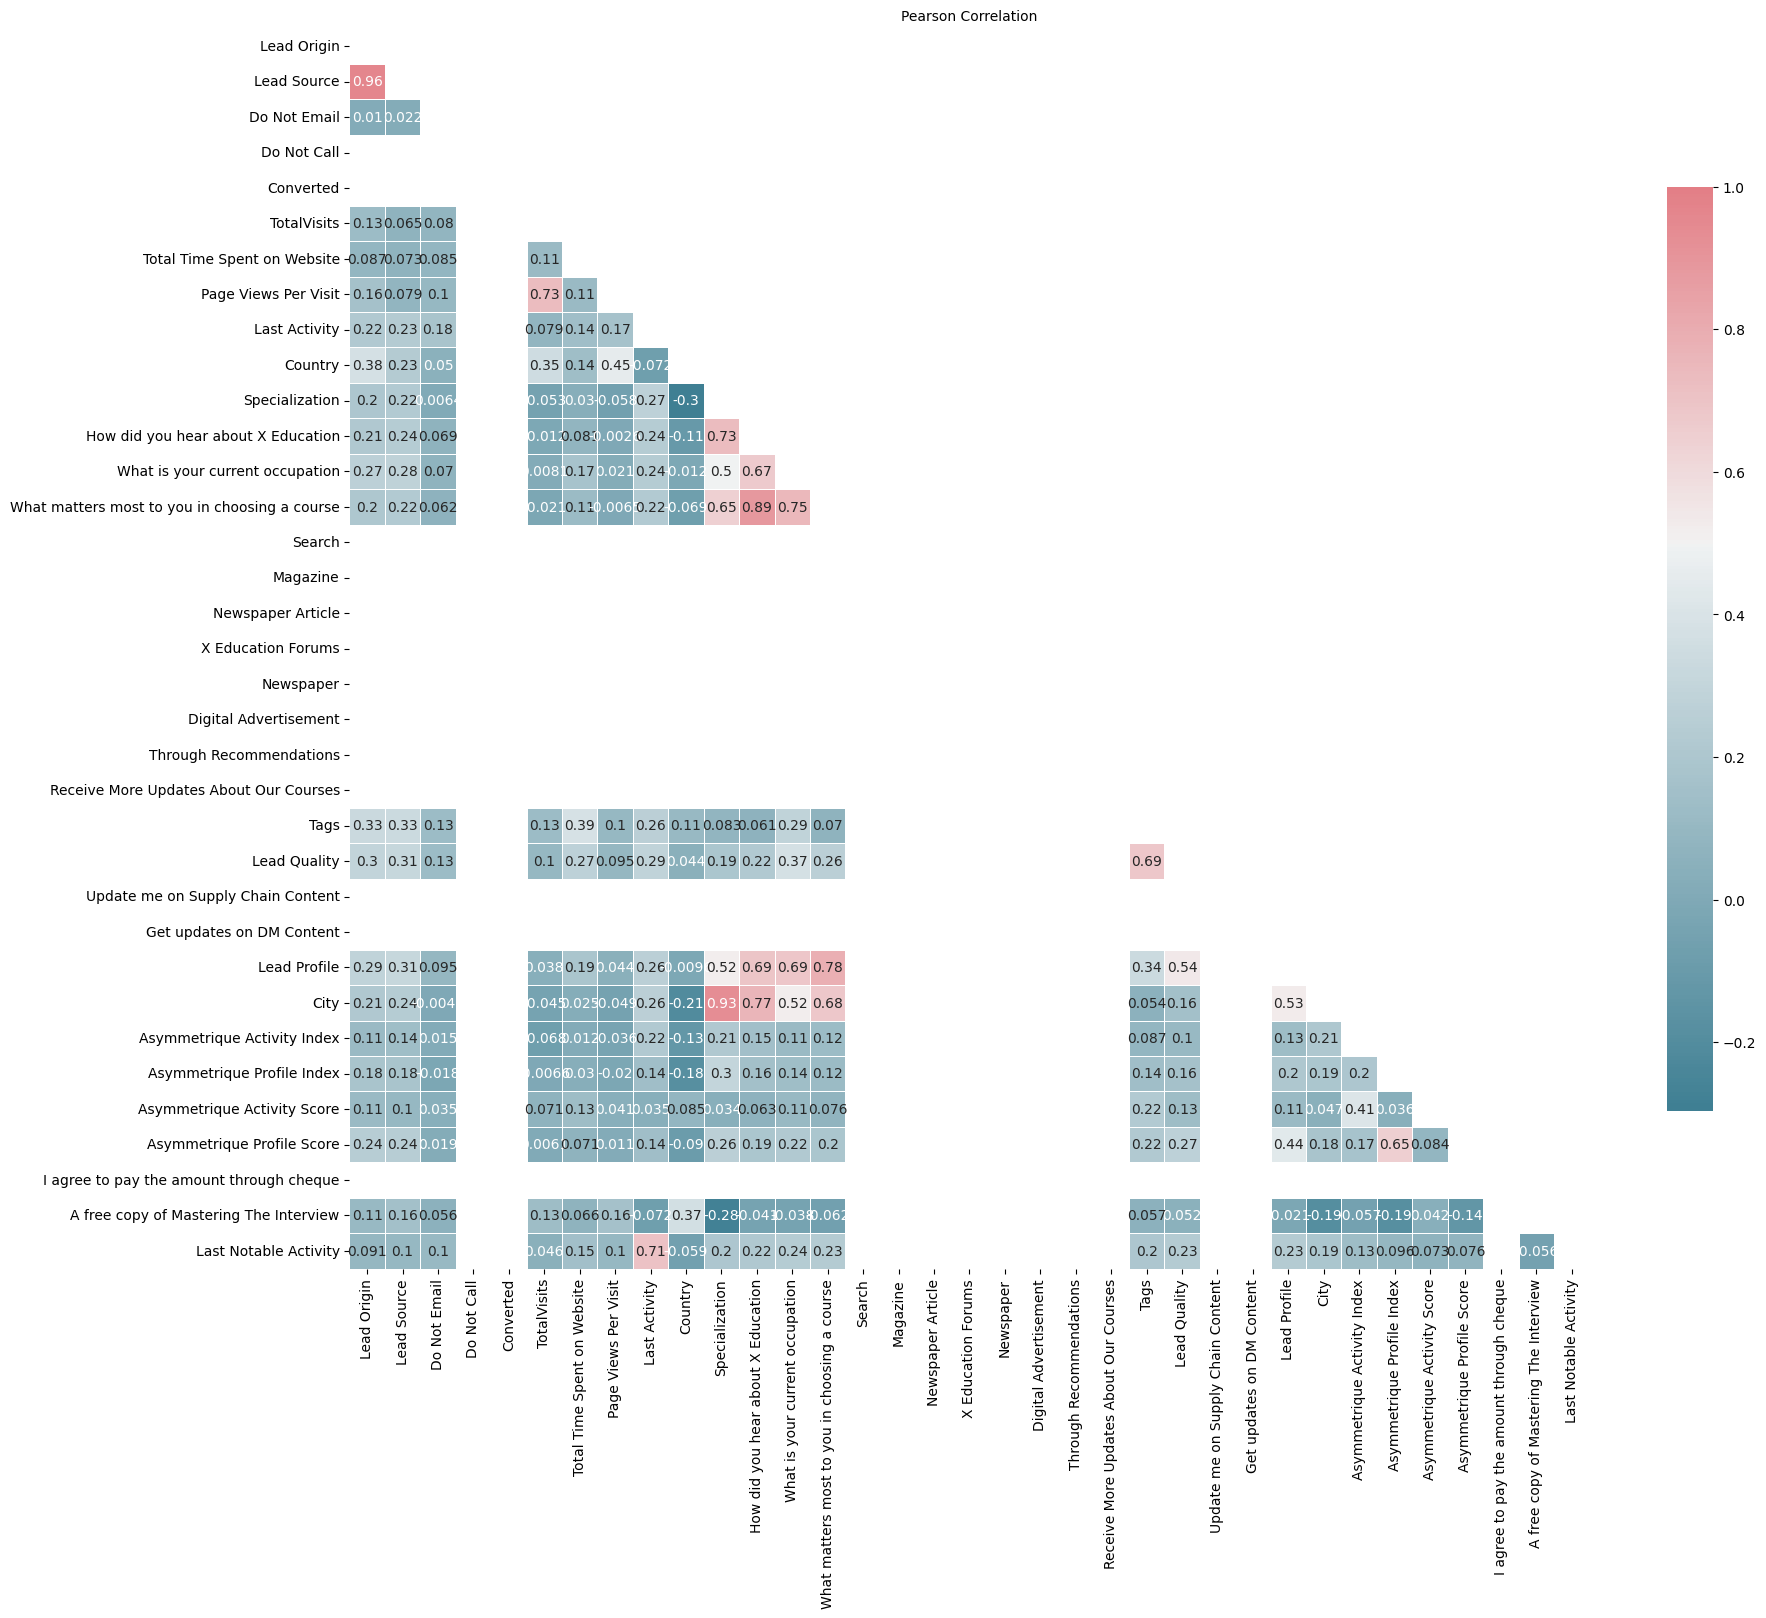

In [16]:
data_transform = binning_process.transform(trained_data, metric="woe")
select_var_r3,remove_vars_r3 = select_correlated_iv_features(data_transform,trained_data.columns,iv)


In [17]:
iv[iv['variable'].isin(select_var_r3)]

,variable,iv,unique_bin,top_bin,freq_bin
1,Lead Source,0.658413,5,[3],2295
2,Do Not Email,0.108354,2,[0],6794
4,Last Activity,0.845716,4,"[3, 13, 5]",3054
18,Tags,4.824130,5,"[16, 26, 20, 5, 18, 15, 1]",2842
22,Lead Profile,1.088576,4,[4],3314
24,Asymmetrique Activity Index,0.075660,3,[3],3355
30,TotalVisits,0.081661,6,"[3.50, 7.50)",2161
31,Total Time Spent on Website,1.065929,5,"[1.50, 416.50)",2860
33,Asymmetrique Activity Score,0.383068,5,Missing,3355
34,Asymmetrique Profile Score,0.182607,5,Missing,3355


In [18]:
import pandas as pd
import numpy as np
binning_info = df_binning_table.reset_index()
def transform_data(data, binning_info, selected_var):
    for var in binning_info['level_0'].unique():
        if var in selected_var:
            binning_table = binning_info[binning_info['level_0'] == var]
            bins = []
            is_continuous = True
            
            for bin_range in binning_table['Bin'].astype(str):  # Ensure bin_range is a string
                try:
                    # Check if the bin is continuous
                    if ',' in bin_range:
                        bins.append(float(bin_range.split(',')[0][1:]))
                    else:
                        is_continuous = False
                        bins.append(bin_range)
                except ValueError:
                    bins.append(np.nan)
                    print(var, 1)
            
            if is_continuous:
                if not all(x < y for x, y in zip(bins, bins[1:]) if pd.notna(x) and pd.notna(y)):
                    raise ValueError(f"Bins for variable {var} are not monotonically increasing")
                bins = [-np.inf] + [b for b in bins if pd.notna(b)] + [np.inf]  # Add -inf and inf to handle all ranges
                bins = pd.Series(bins).drop_duplicates().tolist()  # Remove duplicate edges
                labels = range(len(bins) - 1)
                data[var + '_binned'] = pd.cut(data[var], bins=bins, labels=labels, include_lowest=True)
            else:
                # For discrete bins, use the unique values as labels
                data[var + '_binned'] = pd.cut(data[var], bins=len(bins), labels=bins, include_lowest=True)

    # Select the binned variables for further processing
    binned_vars = [var + '_binned' for var in selected_var if var + '_binned' in data.columns]

    # Convert the binned data to dummy/one-hot encoded variables and convert them to integer type
    dummy_binned_data = (pd.get_dummies(data[binned_vars], prefix=binned_vars, drop_first=True)).astype(int)

    return dummy_binned_data

# Example usage:
transformed_trained_data = transform_data(trained_data, binning_info, select_var_r3)
transformed_test_data = transform_data(test_data, binning_info, select_var_r3)

In [19]:
missing_values_percentage = round(100 * (trained_data[select_var_r3].isna().sum() / len(trained_data[select_var_r3])), 2)
sorted_missing_values_percentage = missing_values_percentage.sort_values(ascending=False)
sorted_missing_values_percentage

Asymmetrique Activity Score    45.39
Asymmetrique Profile Score     45.39
TotalVisits                     1.53
Lead Source                     0.00
Do Not Email                    0.00
Last Activity                   0.00
Tags                            0.00
Lead Profile                    0.00
Asymmetrique Activity Index     0.00
Total Time Spent on Website     0.00
dtype: float64

In [20]:
transformed_trained_data

,Lead Source_binned_[1],Lead Source_binned_[7],Lead Source_binned_[3],Lead Source_binned_[21 10 14 13 4 0],Lead Source_binned_,Do Not Email_binned_[0],Do Not Email_binned_,Last Activity_binned_[15 7 10 14],Last Activity_binned_[ 3 13 5],Last Activity_binned_[12 8 17 6 11 0],...,Asymmetrique Activity Score_binned_13.5,Asymmetrique Activity Score_binned_14.5,Asymmetrique Activity Score_binned_15.5,Asymmetrique Activity Score_binned_Missing,Asymmetrique Activity Score_binned_,Asymmetrique Profile Score_binned_14.5,Asymmetrique Profile Score_binned_15.5,Asymmetrique Profile Score_binned_18.5,Asymmetrique Profile Score_binned_Missing,Asymmetrique Profile Score_binned_
9067,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
6093,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
855,1,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
6053,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
292,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8331,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2105,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,0
8667,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
2490,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0


## ii. Logistic Regression model with optimized parameters

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

X_train = transformed_trained_data
y_train = trained_data['Converted']
x_test = transformed_test_data
y_test = test_data['Converted']
logistic_model = LogisticRegression()

# Define the hyperparameter space
param_distributions = {
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}
random_search = RandomizedSearchCV(logistic_model, param_distributions, n_iter=50, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions on the tested data
y_pred = best_model.predict(x_test)

# Evaluate the model (accuracy & report_dict)
accuracy = accuracy_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)

c:\Master of Data Science\Docs\Python\env\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Accuracy: 0.8685064935064936
AUC Score: 0.9302710575249249


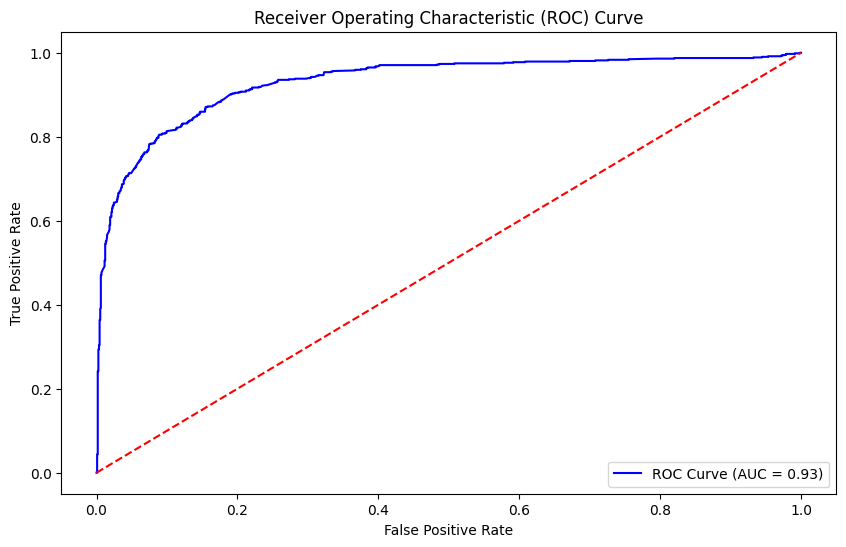

In [22]:
print(f"Accuracy: {accuracy}")
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = best_model.predict_proba(x_test)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print("AUC Score:", auc_score)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## iii. Baseline Logistic Regression model

In [23]:
trained_data, test_data = train_test_split(data.fillna(0), test_size=0.2, random_state=42, stratify=data['Converted'])

x_train_base_line  = trained_data.drop(columns = 'Converted')
y_train_base_line  = trained_data['Converted']
x_test_base_line  = test_data.drop(columns = 'Converted')
y_test_base_line  = test_data['Converted']
logistic_model_base_line = LogisticRegression()

logistic_model_base_line.fit(x_train_base_line, y_train_base_line)
y_pred = logistic_model_base_line.predict(x_test_base_line)

accuracy = accuracy_score(y_test_base_line, y_pred)
report_dict = classification_report(y_test_base_line, y_pred, output_dict=True)

c:\Master of Data Science\Docs\Python\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
x_train_base_line.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
       'Last Activity', 'Country', 'Specialization',
       'How did you hear about X Education', 'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags', 'Lead Quality',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'Asymmetrique Activity Index',
       'Asymmetrique Profile Index', 'Asymmetrique Activity Score',
       'Asymmetrique Profile Score',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

Accuracy: 0.8181818181818182
AUC Score: 0.8822468695600569


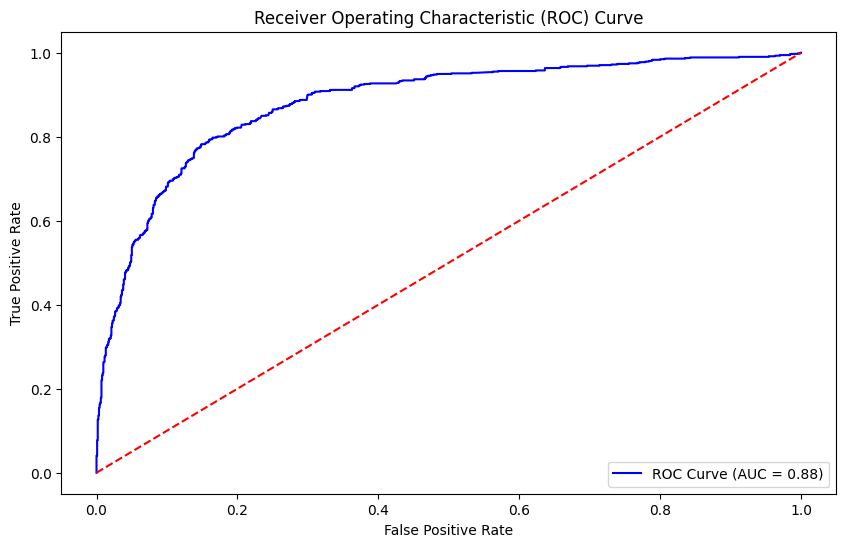

In [25]:
print(f"Accuracy: {accuracy}")
y_pred_proba = logistic_model_base_line.predict_proba(x_test_base_line)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test_base_line, y_pred_proba)

# Calculate the AUC score
auc_score = roc_auc_score(y_test_base_line, y_pred_proba)
print("AUC Score:", auc_score)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## iv. XGBOOST with optimized parameters 

c:\Master of Data Science\Docs\Python\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8869047619047619
AUC Score: 0.9572643021047633


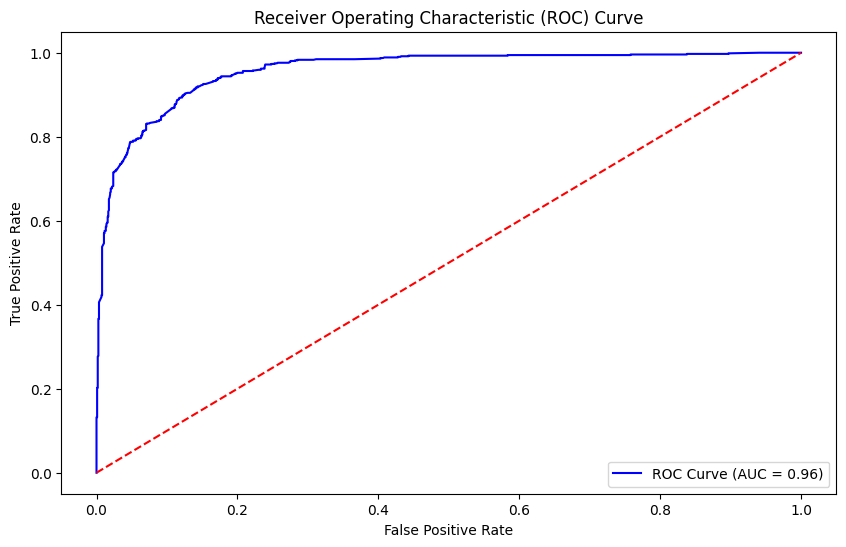

In [26]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Training and testing datasets
x_trained_data = transformed_trained_data
y_train_labels = trained_data['Converted']
x_test_data = transformed_test_data
y_test_labels = test_data['Converted']

# Hyperparameter search space
xgb_hyperparams = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Function to clean column names
def sanitize_column_names(df):
    df.columns = df.columns.str.replace('[', '_', regex=False)
    df.columns = df.columns.str.replace(']', '_', regex=False)
    df.columns = df.columns.str.replace('<', '_', regex=False)
    df.columns = df.columns.str.replace('>', '_', regex=False)
    df.columns = df.columns.astype(str)
    return df

# Clean column names for training and testing data
x_trained_data = sanitize_column_names(x_trained_data)
x_test_data = sanitize_column_names(x_test_data)

# Initialize the XGBoost classifier
xgboost_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Perform RandomizedSearchCV to find the best hyperparameters
xgb_random_search = RandomizedSearchCV(xgboost_model, xgb_hyperparams, n_iter=50, cv=5, random_state=42, n_jobs=-1)
xgb_random_search.fit(x_trained_data, y_train_labels)

# Retrieve the best model after hyperparameter tuning
best_xgb_model = xgb_random_search.best_estimator_

# Make predictions on the test data
y_test_predictions = best_xgb_model.predict(x_test_data)

# Evaluate the model performance
model_accuracy = accuracy_score(y_test_labels, y_test_predictions)
classification_report_dict = classification_report(y_test_labels, y_test_predictions, output_dict=True)

print(f"Accuracy: {model_accuracy}")

# Get prediction probabilities for calculating ROC curve and AUC score
y_test_pred_probabilities = best_xgb_model.predict_proba(x_test_data)[:, 1]

# Calculate false positive rate (FPR), true positive rate (TPR), and thresholds for ROC curve
false_positive_rate, true_positive_rate, roc_thresholds = roc_curve(y_test_labels, y_test_pred_probabilities)
roc_auc_score_value = roc_auc_score(y_test_labels, y_test_pred_probabilities)

print("AUC Score:", roc_auc_score_value)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(false_positive_rate, true_positive_rate, color='blue', label=f'ROC Curve (AUC = {roc_auc_score_value:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


# 2. Find the optimal threshold

In [27]:
# Define the range of thresholds to evaluate
threshold_values = np.arange(0.4, 0.9, 0.05)

# Get the predicted probabilities from the best model
y_test_pred_probabilities = best_xgb_model.predict_proba(x_test_data)[:, 1]

# Initialize variables to store the best threshold and the corresponding accuracy
optimal_threshold = 0.0
highest_accuracy = 0.0

# Iterate through each threshold value
for threshold in threshold_values:
    # Apply the threshold to get binary predictions
    y_threshold_predictions = (y_test_pred_probabilities >= threshold).astype(int)
    
    # Calculate accuracy for the current threshold
    current_accuracy = accuracy_score(y_test_labels, y_threshold_predictions)
    
    # Update the best threshold if the current accuracy is higher
    if current_accuracy > highest_accuracy:
        highest_accuracy = current_accuracy
        optimal_threshold = threshold

# Output the best threshold and corresponding accuracy
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Highest Accuracy: {highest_accuracy}")


Optimal Threshold: 0.6499999999999999
Highest Accuracy: 0.8885281385281385
